# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install -U pip sagemaker smdebug awscli

  Using cached pip-23.0-py3-none-any.whl (2.1 MB)
  Using cached sagemaker-2.132.0-py2.py3-none-any.whl
  Using cached awscli-1.27.69-py3-none-any.whl (4.0 MB)
  Using cached boto3-1.26.69-py3-none-any.whl (132 kB)
  Using cached schema-0.7.5-py2.py3-none-any.whl (17 kB)
  Using cached botocore-1.29.69-py3-none-any.whl (10.4 MB)
  Using cached s3transfer-0.6.0-py3-none-any.whl (79 kB)
  Using cached contextlib2-21.6.0-py2.py3-none-any.whl (13 kB)
  Attempting uninstall: pip
    Found existing installation: pip 22.0.3
    Uninstalling pip-22.0.3:
      Successfully uninstalled pip-22.0.3
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.13
    Uninstalling botocore-1.24.13:
      Successfully uninstalled botocore-1.24.13
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.5.2
    Uninstalling s3transfer-0.5.2:
      Successfully uninstalled s3transfer-0.5.2
  Attempting uninstall: boto3
    Found existing installation: boto3 1.2

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import numpy as np

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs, CollectionConfig,
    DebuggerHookConfig, ProfilerConfig, FrameworkProfile
)  
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from torchvision.datasets import ImageFolder

from PIL import Image
import io
import random

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [2]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-07 22:52:10--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.40
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  27.9MB/s    in 28s     

2023-02-07 22:52:40 (38.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [5]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/project3-img-data"
role = sagemaker.get_execution_role()

In [6]:
local_dir = 'dogImages'
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-145975612560/sagemaker/project3-img-data


In [16]:
trainset = ImageFolder(root="dogImages/train")
testset = ImageFolder(root="dogImages/test")
validset = ImageFolder(root="dogImages/valid")

print(f"trainset: {trainset}\n testset: {testset}\n validset: {validset}")

trainset: Dataset ImageFolder
    Number of datapoints: 6680
    Root location: dogImages/train
 testset: Dataset ImageFolder
    Number of datapoints: 836
    Root location: dogImages/test
 validset: Dataset ImageFolder
    Number of datapoints: 835
    Root location: dogImages/valid


In [29]:
print("Number of classes in trainset:", len(trainset.classes))
print(trainset.classes[0:5])

Number of classes in trainset: 133
['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute']


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/project3-img-data"
role = sagemaker.get_execution_role()

In [8]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

In [9]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [ ]:
!pygmentize 'hpo.py'

In [10]:
#TODO: Create estimators for your HPs

# TODO: Your estimator here (instance_type="ml.m5.large")
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

In [11]:
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [12]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels
inputs = "s3://{}/{}" .format(bucket, prefix)

In [13]:
tuner.fit({'train' : inputs}, wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................................!


In [14]:
# TODO: Get the best estimators and the best HPs

#TODO
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-10 21:20:13 Starting - Found matching resource for reuse
2023-02-10 21:20:13 Downloading - Downloading input data
2023-02-10 21:20:13 Training - Training image download completed. Training in progress.
2023-02-10 21:20:13 Uploading - Uploading generated training model
2023-02-10 21:20:13 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '3',
 'lr': '0.004528312628061495',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-10-21-03-42-538"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-145975612560/pytorch-training-2023-02-10-21-03-42-538/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [4]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/project3-img-data"
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

In [5]:
hyperparameters = {
    "lr": "0.004528312628061495",
    "batch-size": "256",
    "epochs": "3"
}

In [6]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [7]:
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(
    #hook_parameters={"train.save_interval": "10", "eval.save_interval": "10"}
    collection_configs=collection_configs    
)

In [ ]:
!pygmentize 'train_model.py'

In [8]:
# TODO: Create and fit an estimator

# TODO: Your estimator here
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    base_job_name="sm-project3-dogImg-pytorch",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [9]:
inputs = "s3://{}/{}" .format(bucket, prefix)

In [10]:
estimator.fit({"train": inputs}, wait=True)

2023-02-10 22:59:30 Starting - Starting the training job...
2023-02-10 22:59:51 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-02-10 23:00:58 Downloading - Downloading input data.........
2023-02-10 23:02:32 Training - Downloading the training image..................
2023-02-10 23:05:33 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-10 23:05:24,853 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-10 23:05:24,882 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-10 23:05:24,886 sagemaker_pytorch_container.training INFO     Invoking user training s

In [11]:
# TODO: Plot a debugging output.

training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=training_job_name)

print(training_job_name)
print(region)
print(description)

sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613
us-east-1
{'TrainingJobName': 'sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:145975612560:training-job/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch-size': '"256"', 'epochs': '"3"', 'lr': '"0.004528312628061495"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.c

In [12]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-10 23:22:25.668 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:254 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/debug-output


In [13]:
trial.tensor_names()

[2023-02-10 23:23:20.939 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:254 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-02-10 23:23:21.958 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:254 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [14]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

9

In [15]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

16

In [16]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


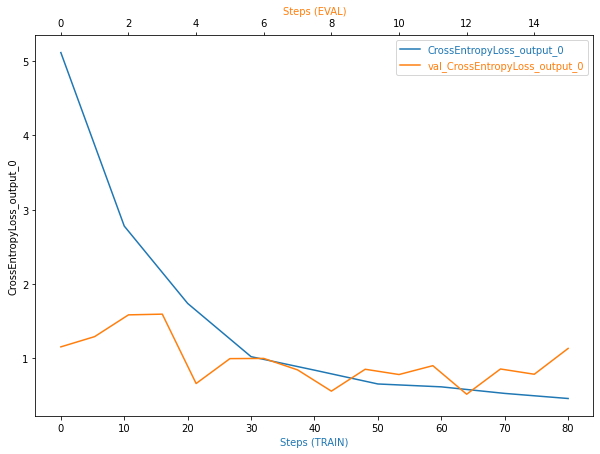

In [18]:
%matplotlib inline

plot_tensor(trial, "CrossEntropyLoss_output_0")

In [19]:
#Checking System Utilization
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-145975612560/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/profiler-output


Profiler data from system is available


In [20]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-02-10 23:23:49.058 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:254 INFO metrics_reader_base.py:134] Getting 11 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [21]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output


In [22]:
! aws s3 ls {rule_output_path} --recursive

2023-02-10 23:11:36     425519 sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-10 23:11:36     283377 sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-10 23:11:31        553 sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-10 23:11:31      20675 sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-10 23:11:31       1651 sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-10 23:11:31        339 sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-10 23:11:31       2989 sm-project3-dogImg-pytorch-2023-02-

In [23]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-

In [24]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [4]:
role = sagemaker.get_execution_role()

In [5]:
#s3_model_artifact = estimator.model_data
s3_model_artifact = "s3://sagemaker-us-east-1-145975612560/sm-project3-dogImg-pytorch-2023-02-10-22-59-29-613/output/model.tar.gz"

In [6]:
# TODO: Deploy your model to an endpoint

# Creating a PyTorchModel object from the estimator.
model = PyTorchModel(
    entry_point="inference.py",
    role=role,
    model_data=s3_model_artifact,
    framework_version="1.8",
    py_version="py36",
)

In [7]:
# TODO: Add your deployment configuration like instance type and number of instances

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    serializer=IdentitySerializer("image/jpeg"),
    deserializer=JSONDeserializer(),
)

----------!

Test image 1
Name: dog_peruvian_hairless.jpg


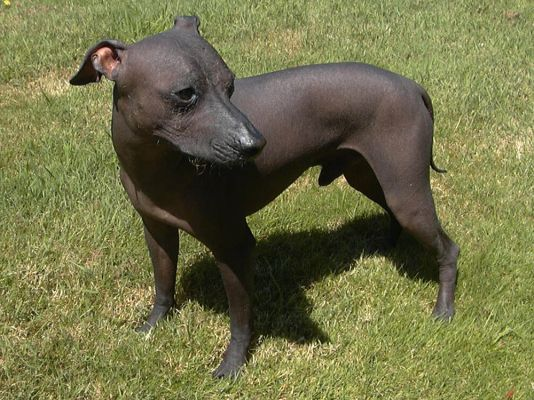

Inferred class: 132.Xoloitzcuintli
Image example of inferred class


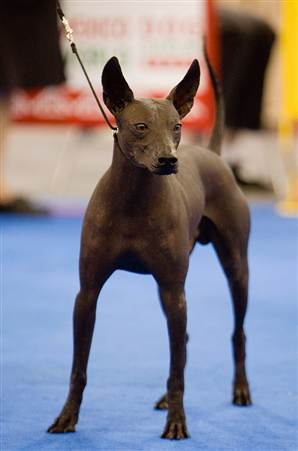

Response:
 [[-5.406714916229248, -5.8086323738098145, -6.77952766418457, -3.861051082611084, -7.137460708618164, -5.327359199523926, -5.052888870239258, -0.2601272165775299, -2.6359546184539795, -3.871537685394287, -3.129209518432617, -8.116541862487793, -5.592459201812744, -3.007084846496582, -5.3551506996154785, -7.134943008422852, -6.514161586761475, -6.428006649017334, -3.7773613929748535, -0.3882339298725128, -6.216717720031738, -6.208232402801514, -9.6094331741333, -6.619321346282959, -6.029290676116943, -7.191885948181152, -6.3977766036987305, -5.363170623779297, -8.502634048461914, -5.605652332305908, -6.942673206329346, -1.2521812915802002, -5.435351371765137, -2.303535223007202, -4.6843767166137695, -5.914670944213867, -6.303122520446777, -4.015964984893799, 0.010807408019900322, -5.874302387237549, -3.3252058029174805, -5.315745830535889, -3.421255111694336, -0.27982383966445923, -5.255447864532471, -8.952019691467285, -3.8979432582855225, -0.14011181890964508, -1.5975419282

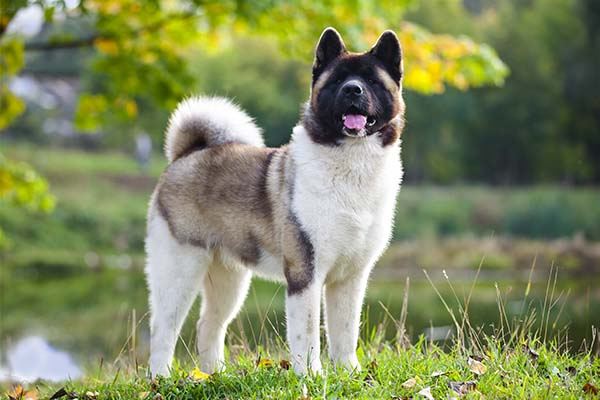

Inferred class: 109.Norwegian_elkhound
Image example of inferred class


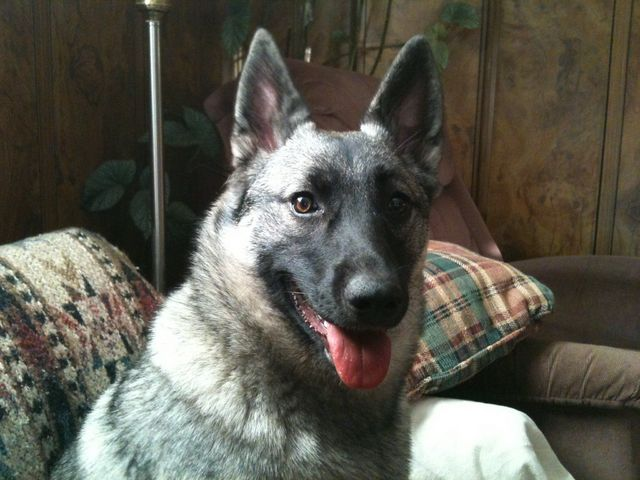

Response:
 [[-6.967377662658691, -3.9927282333374023, -7.176419734954834, 2.663391351699829, 1.2318601608276367, -2.401265859603882, -7.319026470184326, -8.167606353759766, -6.673419952392578, -1.48359215259552, -0.528667688369751, -3.1217408180236816, -6.644504547119141, -3.0501222610473633, -8.431023597717285, -9.279107093811035, -7.489648818969727, -5.6875128746032715, -3.2184689044952393, -0.2814314365386963, -2.8843634128570557, -1.4093011617660522, -5.826470851898193, -7.464653968811035, -12.540367126464844, -6.779012203216553, -11.333953857421875, -8.37108039855957, -3.5408923625946045, -8.88358211517334, -1.5398647785186768, -4.139311790466309, -2.249119997024536, -7.309948444366455, -8.412226676940918, -3.7258195877075195, -6.5198588371276855, -6.029836177825928, -4.921990394592285, -8.822507858276367, -8.653660774230957, -5.892588138580322, 0.8234461545944214, -5.481876850128174, -0.8722275495529175, -8.029288291931152, -7.916679382324219, -4.188989639282227, -5.7360873222351

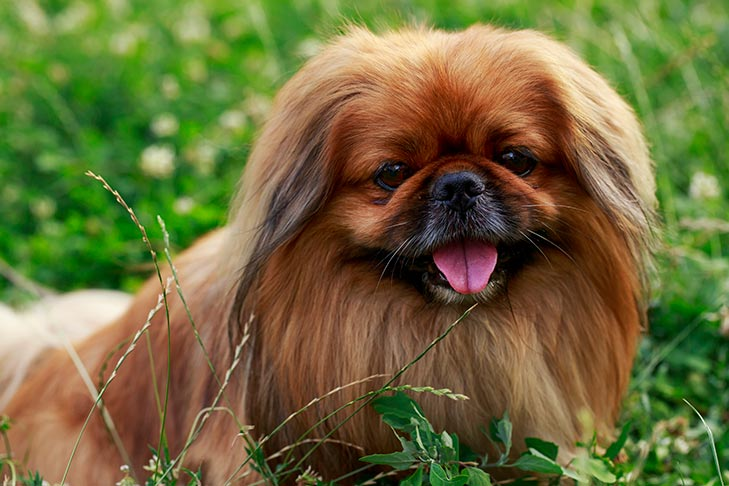

Inferred class: 117.Pekingese
Image example of inferred class


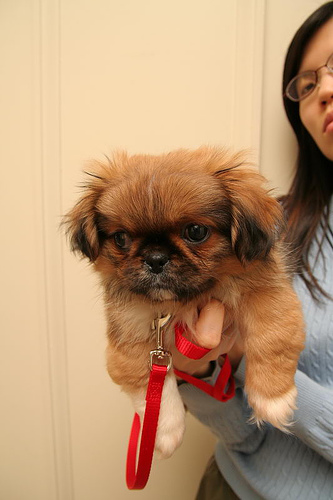

Response:
 [[0.029924649745225906, -2.844309091567993, -8.875371932983398, -5.913300514221191, -9.290423393249512, -5.572286605834961, -8.711163520812988, -9.162217140197754, -5.249945163726807, -7.880258560180664, -7.102407455444336, -4.93734073638916, -2.9241678714752197, -9.711069107055664, -6.7103047370910645, -6.041107654571533, -4.338191032409668, -9.695098876953125, -11.115836143493652, -9.210841178894043, -8.09096908569336, -7.4130449295043945, -7.219048976898193, -3.7785348892211914, -7.553531169891357, -6.440988540649414, -7.873764514923096, -8.552882194519043, -10.980780601501465, -4.92425537109375, -9.275510787963867, -2.275857925415039, -4.745300769805908, -2.197348117828369, -3.7312052249908447, -2.4315176010131836, -5.042893886566162, 4.947513103485107, -11.212897300720215, -1.33902907371521, -2.635786533355713, -5.653748989105225, -8.49415397644043, -4.7369842529296875, -7.201544284820557, 2.468360185623169, -9.743491172790527, -2.0010721683502197, -4.148715019226074, -

In [14]:
# TODO: Run an prediction on the endpoint
testset = ImageFolder(root="dogImages/test")

for i, filename in enumerate(os.listdir("img")):  
    image = os.path.join("img", filename)
    
    if filename.endswith(".jpg"):
        with open(image, "rb") as img:
            payload = img.read()
            
        response = predictor.predict(payload)
        inference_class = int(np.argmax(response, 1)[0])

        print(f"Test image {i+1}")
        print(f"Name: {filename}")

        display(Image.open(io.BytesIO(payload)))
        print("Inferred class:", testset.classes[inference_class])
        
        example_img_path = os.path.join("dogImages/test", testset.classes[inference_class])
        example_img = random.choice(os.listdir(example_img_path))
        example_img = os.path.join(example_img_path, example_img)
          
        if  example_img.endswith(".jpg"):
            with open(example_img , "rb") as img:
                img = img.read()
            print("Image example of inferred class")
            display(Image.open(io.BytesIO(img)))
        
        print(f"Response:\n {response}\n")

In [15]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()